In [1]:
# Load the necessary python packages for analysis
import numpy as np
import nibabel as nib
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import nilearn
import string
import glob
import pathlib
import json
import seaborn as sns

/home/p.lanka/.local/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [3]:
# Set file paths to access the necessary data

project_folder = '/work/qlab_nu/sing_images/blast_adult' #Set the project folder path 
fmriprep_folder= os.path.join(project_folder, 'preproc', 'derivatives','fmriprep') # Make sure this folder points to the fMRI prep folder
bids_folder= os.path.join(project_folder, 'preproc', 'bids') # Make sure this folder points to BIDS directory
output_folder = os.path.join(project_folder, 'preproc', 'derivatives', 'linstats') # This is the folder that saves the first level models
os.makedirs(output_folder, exist_ok= True)

In [6]:
# Extract the subject IDs of all the subjects available for  analysis
task = "langloc" #Set the task. Should match the BIDS file name
output_folder = os.path.join(output_folder, task)
os.makedirs(output_folder,exist_ok= True)
no_runs =2 # Max number of runs for each subject
restcond = 'fix'
# Search the potential subject names in fMRIprep folder
potential_sub_list = [pathlib.PurePath(file).name for file in glob.iglob(os.path.join(fmriprep_folder , "sub-*/"))]
runs_avail= {}
scans_avail={}
for sub in potential_sub_list:
    sub_strng = "{}_task-{}_run-0[1-{}]_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz".format(sub,task, no_runs)
    scans_avail[sub]= [pathlib.PurePath(file).name for file in glob.iglob(os.path.join(fmriprep_folder, sub,'func', sub_strng))]
    runs_avail[sub] = [int(f.split('_')[2][-1]) for f in scans_avail[sub]]
    
    
# Lets remove the subjects by removing subjects with no scans
scans_avail  = {sub:val for sub, val in scans_avail.items() if val} 
runs_avail  = {sub:val for sub, val in runs_avail.items() if val} 

#Further lets remove the scans with empty event files

stimcond= "trial_type"  # THe column in the event file which is used for the modeling the stimuli in the GLM
conditions= set()
subject_cond = {}# This will have information about conidtions avaialable for each subject across all available runs.
everuns_avail={}
subject_run_conds = {} # This will save  informatin about conditions in wach run

for sub, runs in runs_avail.items():
    conds =set()
    everuns=[]
    conds_run =[]
    for run in runs:
        eve_filename= "{}_task-{}_run-0{}_events.tsv".format(sub, task, run)
        events = pd.read_csv(os.path.join(bids_folder, sub, 'func', eve_filename), sep='\t')
        if len(events.index) >0:
            everuns.append(run)
            conds = conds.union(set(events[stimcond]))
            conds_run.append(list(np.unique(events[stimcond])))
    everuns_avail[sub]=everuns
    subject_cond[sub] = list(conds)
    conditions = conditions.union(conds)
    subject_run_conds[sub] = conds_run 
    
 # Now lets remove the subjects who do not have all the needed conditions in their runs   
subject_cond = {subs:conds  for subs, conds in subject_cond.items() if set(conds)==set(conditions)}               
runs_avail  = {sub:run for sub, run in runs_avail.items() if run and sub in subject_cond.keys()}
subject_run_conds  = {sub:cond for sub, cond in subject_run_conds.items() if sub in subject_cond.keys()}
conditions =list(conditions)

In [7]:
# Now lets print the subject list and runs avaiable forthe task analysis

print("For the task",task, "the following subjects and runs are available for analyses:")
for sub, runs in runs_avail.items():
    print(sub, ' '.join(map(str ,runs)))
    
final_subject_list = runs_avail
R = 'Y'
while R=='Y':
    R = input("Do you want to remove any subjects? Y or N")
    if R=='Y':
        subs= input("Input a list of subjects you want removed and seperate each subject seperated by commas")
        subs = subs.split(", ")
        for s in subs:
            if s in final_subject_list.keys():
                del final_subject_list[s]
    elif R=='N':
        break;
    else:
        print("Please enter either Y or N as valid output")
        R='Y'
        
print("For the task",task, "the final list of subjects and runs will be used for analyses:")
for sub, runs in final_subject_list.items():
    print(sub, ' '.join(map(str ,runs)))

For the task langloc the following subjects and runs are available for analyses:
sub-blasta001 1 2
sub-blasta002 1 2
sub-blasta004 1 2
sub-blasta005 1 2
sub-blasta006 1 2
sub-blasta007 1 2
sub-blasta008 1 2
sub-blasta010 1 2
sub-blasta011 1 2
sub-blasta012 1 2
sub-blasta013 1 2
sub-blasta014 1 2
sub-blasta015 1 2
sub-blasta017 1 2
sub-blasta018 1 2
sub-blasta020 1 2
sub-blasta021 1 2
sub-blasta023 1 2
sub-blasta024 1 2
sub-blasta025 1 2
sub-blasta027 1 2
sub-blasta028 1 2
sub-blasta035 1 2
sub-blasta038 1 2
sub-blasta039 1 2
sub-blasta044 1 2


Do you want to remove any subjects? Y or N N


For the task langloc the final list of subjects and runs will be used for analyses:
sub-blasta001 1 2
sub-blasta002 1 2
sub-blasta004 1 2
sub-blasta005 1 2
sub-blasta006 1 2
sub-blasta007 1 2
sub-blasta008 1 2
sub-blasta010 1 2
sub-blasta011 1 2
sub-blasta012 1 2
sub-blasta013 1 2
sub-blasta014 1 2
sub-blasta015 1 2
sub-blasta017 1 2
sub-blasta018 1 2
sub-blasta020 1 2
sub-blasta021 1 2
sub-blasta023 1 2
sub-blasta024 1 2
sub-blasta025 1 2
sub-blasta027 1 2
sub-blasta028 1 2
sub-blasta035 1 2
sub-blasta038 1 2
sub-blasta039 1 2
sub-blasta044 1 2


In [8]:
# Estimate run level contrasts
from itertools import chain
def check_contrast_run(cont):
    unq_cond_runs = [list(x) for x in set(tuple(x) for x in list(chain.from_iterable(subject_run_conds.values())))]
    return (any([set(cont.split("minus")).issubset(set(cond)) for cond in unq_cond_runs]))

contrasts_list = list()
while True:
    cont = input("Enter a list of contasts to be calculated. Contrasts should be in the format of cond1minuscond2. If  all entered press Enter")
    if cont:
        if (check_contrast_run(cont) and len(cont.split("minus"))==2):
            contrasts_list.append(cont)
        else:
            print("Contrast not valid. Enter a valid string.")
    else:
        break
        
contrasts_list = list(set(contrasts_list))

Enter a list of contasts to be calculated. Contrasts should be in the format of cond1minuscond2. If  all entered press Enter intactminusdegraded
Enter a list of contasts to be calculated. Contrasts should be in the format of cond1minuscond2. If  all entered press Enter degradedminusfix
Enter a list of contasts to be calculated. Contrasts should be in the format of cond1minuscond2. If  all entered press Enter intactminusfix
Enter a list of contasts to be calculated. Contrasts should be in the format of cond1minuscond2. If  all entered press Enter 


In [9]:
#Estimate subject level contrasts
import copy
contrasts_list_sub = copy.deepcopy(contrasts_list)
print("Contrasts that will be calculated at subject level:")
for c in contrasts_list_sub:
    print(c)
while True:
    cont = input("Enter a list of additional contrasts to be calculated at subject level. Contrasts should be in the format of cond1minuscond2. If  all entered press Enter")
    if cont:
        if (set(cont.split("minus")).issubset(set(conditions)) and len(cont.split("minus"))==2):
            contrasts_list_sub.append(cont)
        else:
            print("Contrast not valid. Enter a valid string.")
    else:
        break
        
contrasts_list_sub = list(set(contrasts_list_sub))

Contrasts that will be calculated at subject level:
intactminusfix
degradedminusfix
intactminusdegraded


Enter a list of additional contrasts to be calculated at subject level. Contrasts should be in the format of cond1minuscond2. If  all entered press Enter 


In [10]:
# Define subject level contrasts. Here the contrasts are calculated across the multiple runs. So we calculate c
import re
from nilearn.glm.contrasts import compute_fixed_effects
from nilearn.image import concat_imgs
from nilearn.glm.first_level import FirstLevelModel
import copy
def estimate_subject_stats (subject, task, contrast, effect_files_list, var_files_list):
    contrast_imgs = list(map(nib.load, effect_files_list))
    variance_imgs = list(map(nib.load, var_files_list))   
    
    # Weighs the effect sizes by the inverse variance in fixed effects modeling
    fixed_fx_contrast_img,fixed_fx_variance_img, fixed_fx_t_image = compute_fixed_effects(contrast_imgs, variance_imgs, mask= nilearn.datasets.fetch_icbm152_brain_gm_mask(), precision_weighted=True)
    fixed_fx_contrast_img.to_filename(os.path.join(output_folder, 'subjectLevel', subject, "{}_task-{}_contrast-{}_stat-effect_statmap.nii.gz".format(subject, task, contrast)))
    fixed_fx_variance_img.to_filename(os.path.join(output_folder, 'subjectLevel', subject, "{}_task-{}_contrast-{}_stat-variance_statmap.nii.gz".format(subject, task, contrast)))   
    fixed_fx_t_image.to_filename(os.path.join(output_folder, 'subjectLevel', subject, "{}_task-{}_contrast-{}_stat-t_statmap.nii.gz".format(subject, task, contrast) ))
    
def create_sublevelContrasts(subject, runs, task, contrasts_list_sub):
    design_matrices_list=  glob.glob(os.path.join(output_folder,'runLevel', subject, "{}_task-{}_run-0{}_design-full.tsv".format(subject, task, runs)))
    design_matrices = [pd.read_csv(file, sep="\t" ) for file in design_matrices_list]
    design_matrices = [ds.drop(columns= 'Unnamed: 0') for ds in design_matrices]                                        
    for i, run in enumerate(runs):
        design_matrices[i].columns =  [col+'_'+ str(run) for col in design_matrices[i].columns]
        if i>0:
            design_matrices[i].index += design_matrices[i-1].index[-1] + 1
    design_matrices_combined = pd.concat(design_matrices)
    design_matrices_combined.fillna(0, inplace=True)
    for r in range(no_runs):
        design_matrices_combined.rename(columns={'constant_{}'.format(r): 'run_{}'.format(r)}, inplace =True, errors = 'ignore')
    design_matrices_combined['constant']=1
    design_matrices_combined.to_csv(os.path.join(output_folder,'subjectLevel', subject, "{}_task-{}_design.tsv".format(subject, task)),sep='\t')                                    
    bold_files_list = glob.glob(os.path.join(fmriprep_folder, subject, 'func', "{}_task-{}_run-0{}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz".format(subject,task, runs)))
    bold_files = list(map(nib.load, bold_files_list))
    bold_data_combined = concat_imgs(bold_files)
    samples_files_list= glob.glob(os.path.join(output_folder,'runLevel', subject, "{}_task-{}_run-0{}_samples.txt".format(subject, task, runs)))
    sample_masks =[np.loadtxt(file, dtype='int') for file in samples_files_list]
    sample_masks_combined = copy.deepcopy(sample_masks)
    for i, run in enumerate(runs):
        sample_masks_combined[i] += i*bold_files[i-1].shape[3] 
    sample_masks_combined = np.concatenate(sample_masks_combined).ravel()
    np.savetxt(os.path.join(output_folder, 'subjectLevel', subject,"{}_task-{}_samples.txt".format(subject, task)),  sample_masks_combined , fmt='%d')                               
    fmri_glm_sub = FirstLevelModel(subject_label='subject', minimize_memory=False);
    fmri_glm_sub = fmri_glm_sub.fit(bold_data_combined , design_matrices=design_matrices_combined, sample_masks=sample_masks_combined);
    contrasts_sub = dict()
    contrasts_runs = dict()
    for cname in contrasts_list_sub:
            cond1, cond2 = tuple(cname.split('minus'))
            if set(cname.split('minus')).issubset(subject_cond[subject]):
                runs_cont = [runs_avail[subject][idx] for idx, conds in enumerate(subject_run_conds[subject]) if set(cname.split('minus')).issubset(set(conds))]
                
                if runs_cont:
                    design_matrices_list_cont=  glob.glob(os.path.join(output_folder,'runLevel', subject, "{}_task-{}_run-0{}_design-full.tsv".format(subject, task, runs_cont)))
                    design_matrices_cont = [pd.read_csv(file, sep="\t" ) for file in design_matrices_list_cont]
                    design_matrices_cont = [ds.drop(columns= 'Unnamed: 0') for ds in design_matrices_cont] 
                    if (runs_cont== runs) and (all([len(ds.columns) for ds in design_matrices_cont])) and (all([set(design_matrices_cont[0].columns)==r for r in [set(ds.columns) for ds in design_matrices_cont[1:]]])):
                        condition_matrix_cont = np.eye(design_matrices_cont[0].shape[1])
                        condition_matrix_cont = {
                        column: condition_matrix_cont[i]
                        for i, column in enumerate(design_matrices_cont[0].columns) if column in conditions
                        }
                        contrasts_runs[cname] = condition_matrix_cont[cond1]- condition_matrix_cont[cond2]
                    else:

                        if (all([len(ds.columns) for ds in design_matrices_cont])) and (all([set(design_matrices_cont[0].columns)==r for r in [set(ds.columns) for ds in design_matrices_cont[1:]]])):
                         # This part of the code is run if the columns of the design matrix are same across different runs 
                            bold_files_list_cont = glob.glob(os.path.join(fmriprep_folder, subject, 'func', "{}_task-{}_run-0{}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz".format(subject,task, runs_cont)))
                            bold_files_cont = list(map(nib.load, bold_files_list_cont))

                            samples_files_list_cont= glob.glob(os.path.join(output_folder,'runLevel', subject, "{}_task-{}_run-0{}_samples.txt".format(subject, task, runs_cont)))
                            sample_masks_cont =[np.loadtxt(file, dtype='int') for file in samples_files_list_cont]
                            fmri_glm_sub_cont = FirstLevelModel(subject_label='subject', minimize_memory=False) ;
                            fmri_glm_sub_cont = fmri_glm_sub_cont.fit(bold_files_cont, design_matrices=design_matrices_cont, sample_masks=sample_masks_cont);
                            condition_matrix_cont = np.eye(design_matrices_cont[0].shape[1])
                            condition_matrix_cont = {
                            column: condition_matrix_cont[i]
                            for i, column in enumerate(design_matrices_cont[0].columns) if column in conditions
                            }
                            contrasts=dict()
                            contrasts[cname] = condition_matrix_cont[cond1]- condition_matrix_cont[cond2]
                            save_glm_to_bids(fmri_glm_sub_cont, contrasts, out_dir=os.path.join(output_folder, 'subjectLevel', subject), prefix= "{}_task-{}".format(subject, task))
                            report_sub_cont = make_glm_report(fmri_glm_sub_cont, contrasts, title= 'Statistical report for subject: {} and task: {}'.format(subject, task), alpha =0.001,  bg_img='MNI152TEMPLATE',cluster_threshold=0, height_control='fpr',min_distance=8.0, plot_type='slice', two_sided=True);
                            report_sub_cont.save_as_html(os.path.join(output_folder, 'subjectLevel', subject, '{}_task-{}_contrast-{}_contrasts-report.html'.format(subject, task, cname)));

                        else:
                             # This part of the code is run if the columns of the design matrix are not same across runs, either due to different nuissance regressors.
                            effect_files_list = glob.glob(os.path.join(output_folder, 'runLevel', subject, "{}_task-{}_run-0[0-9]_contrast-{}_stat-effect_statmap.nii.gz".format(subject, task, cname.lower())))
                            var_files_list = glob.glob(os.path.join(output_folder, 'runLevel', subject, "{}_task-{}_run-0[0-9]_contrast-{}_stat-variance_statmap.nii.gz".format(subject, task, cname.lower())))
                            cstring = os.path.basename(effect_files_list[0])
                            contrast = re.search(r"contrast-[a-z]+", cstring).group().split('-')[1]                            
                            estimate_subject_stats (subject, task, contrast, effect_files_list, var_files_list)
                            
                elif (set(cname.split('minus')+[restcond]).issubset(subject_cond[subject])):          
                    contrast_vals_img = np.zeros(design_matrices_combined.shape[1])
                    cond1_runs = [runs_avail[subject][idx] for idx, conds in enumerate(subject_run_conds[subject]) if set([cond1,restcond]).issubset(set(conds))]
                    cond2_runs = [runs_avail[subject][idx] for idx, conds in enumerate(subject_run_conds[subject]) if set([cond2,restcond]).issubset(set(conds))]
                    c1_runs = len(cond1_runs)
                    c2_runs = len(cond2_runs)
                    cond1_columns = [cond1 +'_'+ str(r) for r in cond1_runs]
                    cond2_columns = [cond2 +'_'+ str(r) for r in cond2_runs]
                    rest1_columns = [restcond +'_'+ str(r) for r in cond1_runs]
                    rest2_columns = [restcond +'_'+ str(r) for r in cond2_runs]
                    contrast_vals_img [[i for i, col in enumerate(design_matrices_combined.columns) if col in cond1_columns]] +=c2_runs/(c1_runs+c2_runs)
                    contrast_vals_img [[i for i, col in enumerate(design_matrices_combined.columns) if col in cond2_columns]] += -1*(c1_runs/(c1_runs+c2_runs))
                    contrast_vals_img [[i for i, col in enumerate(design_matrices_combined.columns) if col in rest1_columns]] += -1*(c2_runs/(c1_runs+c2_runs))
                    contrast_vals_img [[i for i, col in enumerate(design_matrices_combined.columns) if col in rest2_columns]] += c1_runs/(c1_runs+c2_runs)
                    contrasts_sub[cname]= contrast_vals_img
    if contrasts_sub:
        save_glm_to_bids(fmri_glm_sub, contrasts_sub, out_dir=os.path.join(output_folder, 'subjectLevel', subject), prefix= "{}_task-{}_run-all".format(subject, task));
        report_sub = make_glm_report(fmri_glm_sub, contrasts_sub, title= 'Statistical report for subject: {} and task: {}'.format(subject, task), alpha =0.001,  bg_img='MNI152TEMPLATE',cluster_threshold=0, height_control='fpr',min_distance=8.0, plot_type='slice', two_sided=True);
        report_sub.save_as_html(os.path.join(output_folder, 'subjectLevel', subject, '{}_task-{}_run-all_contrasts-report.html'.format(subject, task)));
    if contrasts_runs:
        fmri_glm_sub_runs = FirstLevelModel(subject_label='subject', minimize_memory=False) ;
        fmri_glm_sub_runs = fmri_glm_sub_runs.fit(bold_files, design_matrices=design_matrices, sample_masks=sample_masks);
        save_glm_to_bids(fmri_glm_sub_runs, contrasts_runs, out_dir=os.path.join(output_folder, 'subjectLevel', subject), prefix= "{}_task-{}".format(subject, task));
        report_sub_runs = make_glm_report(fmri_glm_sub_runs, contrasts_runs, title= 'Statistical report for subject: {} and task: {}'.format(subject, task), alpha =0.001,  bg_img='MNI152TEMPLATE',cluster_threshold=0, height_control='fpr',min_distance=8.0, plot_type='slice', two_sided=True);
        report_sub_runs.save_as_html(os.path.join(output_folder, 'subjectLevel', subject, '{}_task-{}_contrasts-report.html'.format(subject, task)));

In [11]:
# We create a design matrix for each condition and run from this function which is then used then to fit the GLM

from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import make_first_level_design_matrix
#from nilearn.interfaces.fmriprep import load_confounds

def get_design_matrix(task, subject, run):
    json_fname = os.path.join(bids_folder, subject, 'func' ,"{}_task-{}_run-0{}_bold.json".format(subject,task, run))
    json_file =  open(json_fname)
    meta_data=json.load(json_file)
    tr = meta_data["RepetitionTime"] # Get the temporal resolution
    bold_fname = os.path.join(fmriprep_folder, subject, 'func', "{}_task-{}_run-0{}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz".format(subject,task, run))
    bold_file = nib.load(bold_fname)
    ntp = nib.load(bold_fname).header['dim'][4] # Total number of timepoints in the BOLD data
    frame_times = np.arange(0, ntp*tr, tr) # Times in sec in which the fMRI data were acquired
    scan_time = ntp*tr 

    # Extract the stimuli information from the event files
    eve_filename= "{}_task-{}_run-0{}_events.tsv".format(subject, task, run)
    events = pd.read_csv(os.path.join(bids_folder, subject, 'func', eve_filename), sep='\t')
    events = events.loc[:,['onset', 'duration']+[stimcond]]
    events=events.rename(columns={stimcond:'trial_type'}) # Change the column of the event condition column to 'trial_type'

    # Get information from the first level confounds to model the nuissance regressors
    confounds_path =os.path.join(fmriprep_folder, subject, 'func', '{}_task-{}_run-0{}_desc-confounds_timeseries.tsv'.format(subject, task, run))
    if not os.path.isfile(confounds_path):
         confounds_path =os.path.join(fmriprep_folder, subject, 'func', '{}_task-{}_run-0{}_desc-confounds_regressors.tsv'.format(subject, task, run))
            
    confounds  = pd.read_table(confounds_path)
    
    # Optional way to get nuissance regressors
    #confounds,sample_masks = load_confounds(bold_fname, strategy=('motion', 'high_pass','compcor'), motion='basic', scrub=0, fd_threshold=2, 
    #                                        std_dvars_threshold=5, compcor='anat_combined', n_compcor=6, demean=True)

    motion_regs= ['framewise_displacement', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
    phys_regs = [col for col in confounds if col.startswith('a_comp_cor')]
    non_steady_regs = [col for col in confounds if col.startswith('non_steady')]
    add_reg_names = motion_regs +phys_regs[0:6] # We only will use the top 6 components
    add_regs = confounds.loc[:,add_reg_names].fillna(0).to_numpy()
    design_matrix = make_first_level_design_matrix(frame_times,events, hrf_model='spm',
                                   drift_model='cosine', high_pass=0.01,
                                   add_regs=add_regs, add_reg_names=add_reg_names);

   # # saving the design matrix
    design_matrix.to_csv(os.path.join(output_folder,'runLevel', subject, "{}_task-{}_run-0{}_design-full.tsv".format(subject, task, run)),sep='\t')
   # plot_design_matrix(design_matrix, output_file = os.path.join(output_folder, 'runLevel',subject, '{}_task-{}_run-0{}_design.svg'.format(subject, task, run)))
    
    
    # Save the regressors correlation matrices   

    reg_corr = design_matrix.loc[:, design_matrix.columns != "constant"].corr().round(2)
    sns.set_theme(style="white")
    mask = np.triu(np.ones_like(reg_corr, dtype=bool), k=1)  # Generate a mask for the upper triangle
    f, ax = plt.subplots(figsize=(20, 20))

    # Create the correlation plot heatmap
    corrplot = sns.heatmap(reg_corr, mask=mask, cmap='RdBu_r', vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5, "format": "%.1f"},annot = True)
    corrplot.tick_params(labelsize=15)
    plt.savefig(os.path.join(output_folder, 'runLevel', subject, '{}_task-{}_run-0{}_corr.svg'.format(subject,task,run)))
    plt.close()
    
   # Timepoints to include. Currently,include vols with FD less than 2 mm and exclude non steady state outliers
    vols_inc = (confounds.loc[:,'framewise_displacement'].fillna(0)< 2) & ~(confounds.loc[:,non_steady_regs].any(axis =1))
    sample_mask= np.array([i for i, val in enumerate(vols_inc) if val])
                                                                         
    return(design_matrix, sample_mask)

In [12]:
# This function creates contrasts within a run for each run. In this case it is condition-rest contrast

def create_runLevelContrasts(subject, run, design_matrix, contrast_list):
    condition_matrix = np.eye(design_matrix.shape[1])
    condition_matrix = {
        column: condition_matrix[i]
        for i, column in enumerate(design_matrix.columns) if column in conditions
    }
    contrasts=dict()
    for cname in contrast_list:
        cond1, cond2 = tuple(cname.split('minus'))
        if set(cname.split('minus')).issubset(set(subject_run_conds[subject][runs_avail[subject].index(run)])):
            contrasts[cname] = condition_matrix[cond1]- condition_matrix[cond2]
    return(contrasts)

In [13]:
from nilearn.reporting import make_glm_report
from nilearn.interfaces.bids import save_glm_to_bids
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_contrast_matrix


def fitrunmodel (task, subject, run):
    design_matrix, sample_mask = get_design_matrix(task, subject,  run);
    np.savetxt(os.path.join(output_folder, 'runLevel', subject,"{}_task-{}_run-0{}_samples.txt".format(subject, task, run)),  sample_mask , fmt='%d') 
    fmri_glm = FirstLevelModel(subject_label='{}_run-0{}'.format(subject, run), minimize_memory=False);
    #print('Fitting a GLM and computing contrasts for subject: {} and run {}'.format(subject, run))
    bold_fname = os.path.join(fmriprep_folder, subject, 'func', "{}_task-{}_run-0{}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz".format(subject,task, run))
    bold_file = nib.load(bold_fname)
    fmri_glm = fmri_glm.fit(bold_file, design_matrices=design_matrix, sample_masks=sample_mask);
    contrasts = create_runLevelContrasts(subject, run, design_matrix, contrasts_list);
    
    # plot the contrast maps
    f, ax = plt.subplots(figsize=(20, 6))
    contrasts_df = pd.DataFrame.from_dict(contrasts, orient='index', columns = design_matrix.columns)
    contrasts_plot = sns.heatmap(contrasts_df, cmap='RdBu_r', vmax=1, vmin=-1, center=0,
                     square=True, linewidths=.5, cbar_kws={"shrink": 0.5, "format": "%.1f"},annot = True)
    contrasts_plot.tick_params(labelsize=12)
    plt.savefig(os.path.join(output_folder, 'runLevel', subject, '{}_task-{}_run-0{}_contrasts.svg'.format(subject, task, run)));
    plt.close()

    ## Now calculating the contrasts stats
    #for contrast_id, contrast_val in contrasts.items(): 
        # plot_contrast_matrix(contrast_val, design_matrix=design_matrix, output_file=os.path.join(output_folder, 'runLevel', subject,'{}_task-{}_run-0{}_contrast_{}.svg'.format(subject, task, run, contrast_id)))
    save_glm_to_bids(fmri_glm, contrasts, out_dir=os.path.join(output_folder, 'runLevel', subject), prefix= "{}_task-{}_run-0{}".format(subject, task, run));
    report = make_glm_report(fmri_glm, contrasts, title= 'Statistical report for subject: {}, task: {} and run: 0{}'.format(subject, task, run), alpha =0.001,  bg_img='MNI152TEMPLATE',cluster_threshold=0, height_control='fpr',min_distance=8.0, plot_type='slice', two_sided=True);
    report.save_as_html(os.path.join(output_folder, 'runLevel', subject, '{}_task-{}_run-0{}_contrasts-report.html'.format(subject, task, run)));

In [45]:
# This code will check if any subjects analysis was already completed. if so skips those subjects

# Check if subjects completed file exits
if (os.path.isfile(os.path.join(output_folder,'Subjects_Completed_{}.txt'.format(task)))):
    with open(os.path.join(output_folder,'Subjects_Completed_{}.txt'.format(task))) as f:
        subjects_completed = f.readlines()
        subjects_completed = [s.strip() for s in subjects_completed if s.strip()]
else:
    f = open(os.path.join(output_folder,'Subjects_Completed_{}.txt'.format(task)), "w")
    f.close()
    subjects_completed =[]

# Create a dictionary so that only subjects who are not previously run are now run
subjects_to_run =dict()
for s, r in final_subject_list.items():
    if s not in subjects_completed:
        subjects_to_run[s] = r    

In [47]:
%%capture cap --no-display
# Run the analysis for the subjects
# Run  subject-level and run-level glm models for subject list
import warnings
from multiprocessing.pool import Pool
from multiprocessing import cpu_count
warnings.simplefilter("ignore")
from tqdm.notebook import tqdm
os.makedirs(os.path.join(output_folder,'runLevel'),exist_ok= True)
os.makedirs(os.path.join(output_folder,'subjectLevel'),exist_ok= True)
pool = Pool(5) #cpu_count()//2) # Using half of all the cpus available to us

def run_subject(subject_runs):
    subject = subject_runs[0]
    runs = subject_runs[1]
    try:
        print('Processing the data for subject: %s\n' %(subject))
        #os.makedirs(os.path.join(output_folder,'runLevel', subject), exist_ok= True)
        #for run  in tqdm(runs):
        #    design_matrix, sample_mask = get_design_matrix(task, subject, run)
        #    fitrunmodel (task, subject, run);
        os.makedirs(os.path.join(output_folder,'subjectLevel', subject), exist_ok= True)
        create_sublevelContrasts(subject, runs, task, contrasts_list_sub);
        f = open(os.path.join(output_folder,'Subjects_Completed_{}.txt'.format(task)), "a")
        f.write("{}\n".format(subject))
        f.close()
    except Exception as error:
        print('Subject: %s could not be completed due to the exception %s' %(subject, error))

output= pool.map(run_subject, list(subjects_to_run.items()));


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

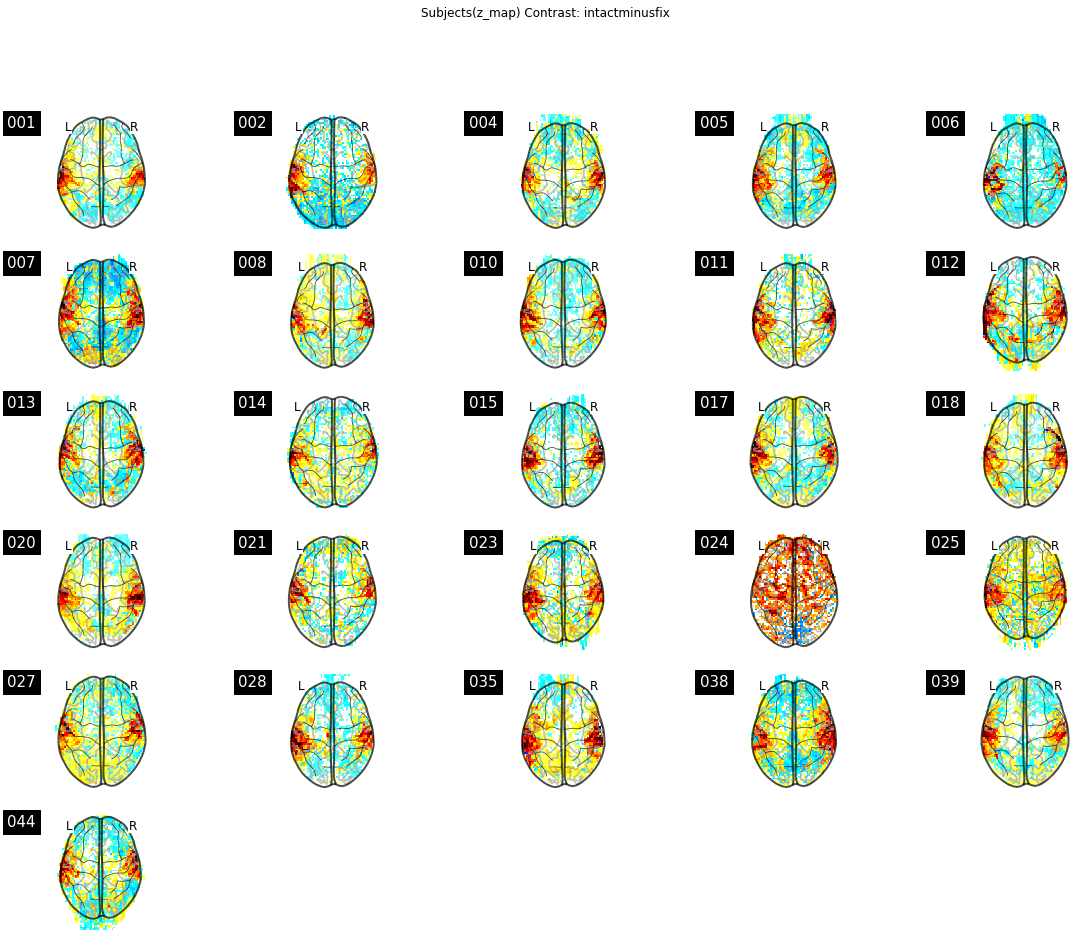

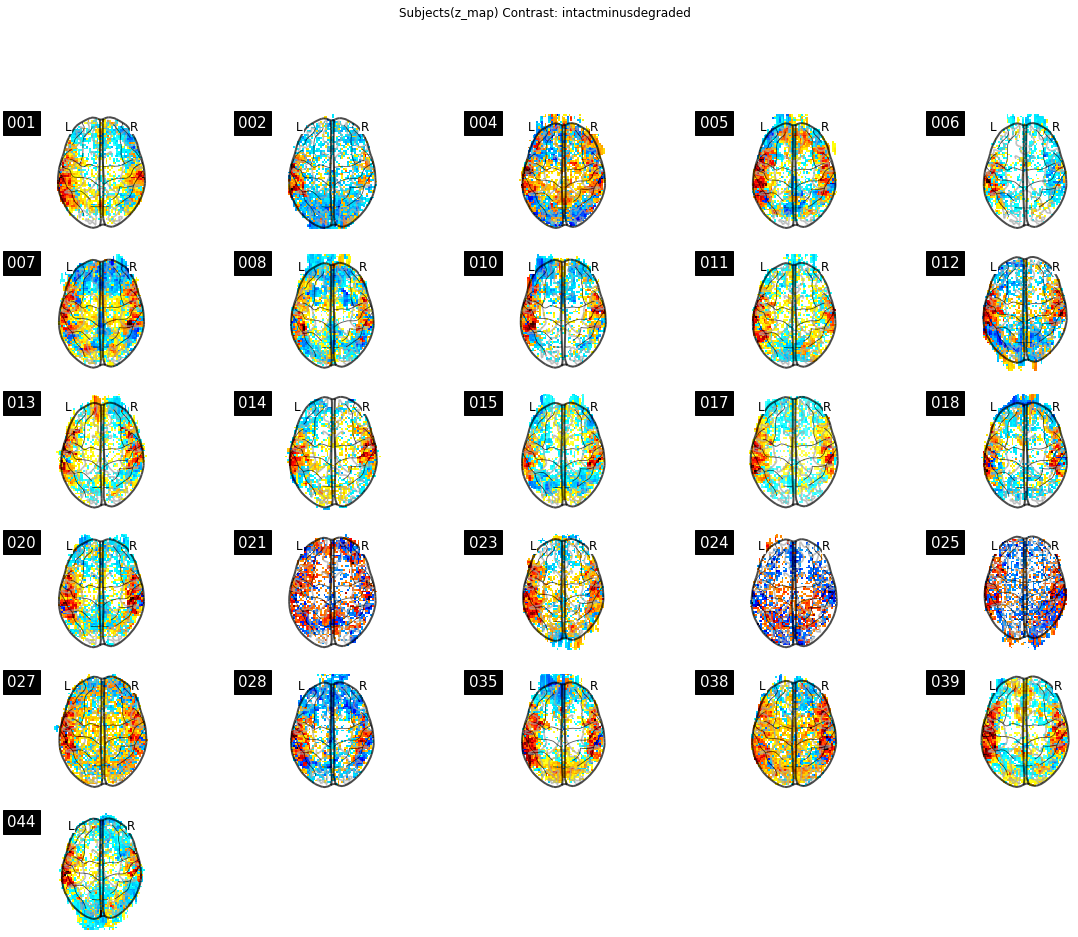

In [ ]:
# Plotting the contrasts for all subjects on a glass brain just to visualize pattern 
from nilearn import plotting
import matplotlib.pyplot as plt
import math
for contrast_id in contrasts_list_sub: 
    subjects_to_plot = sorted(list(set(final_subject_list).intersection(set(map(os.path.basename, glob.glob(os.path.join(output_folder, 'subjectLevel', 'sub-*')))))))
    fig, axes = plt.subplots(nrows= math.ceil(len(subjects_to_plot)/5), ncols=5 , squeeze = False)
    for i, sub in enumerate(subjects_to_plot):
        if contrast_id in contrasts_list:
            zmap_path = os.path.join(output_folder, 'subjectLevel', sub, "{}_task-{}_contrast-{}_stat-z_statmap.nii.gz".format(sub, task, contrast_id.lower()))
        else:
            zmap_path = os.path.join(output_folder, 'subjectLevel', sub, "{}_task-{}_run-all_contrast-{}_stat-z_statmap.nii.gz".format(sub, task, contrast_id.lower()))
            
        try:
            zmap_img = nilearn.image.load_img(zmap_path)
        except ValueError:
            zmap_path = os.path.join(output_folder, 'subjectLevel', sub, "{}_task-{}_contrast-{}_stat-effect_statmap.nii.gz".format(sub, task, contrast_id.lower()))
            zmap_img = nilearn.image.load_img(zmap_path)
        finally:
            plotting.plot_glass_brain(
                zmap_img,
                colorbar=False,
                threshold=3.0,
                title = sub[-3:],
                axes=axes[i//5,i% 5],
                plot_abs=False,
                display_mode='z',
            )

    fig.suptitle('Subjects(z_map) Contrast: {}'.format(contrast_id))
    fig.set_size_inches(20, 15)
    [fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]
    plt.show()